# ML Integrated Project #1

# Project Description

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.

**Technological Process**

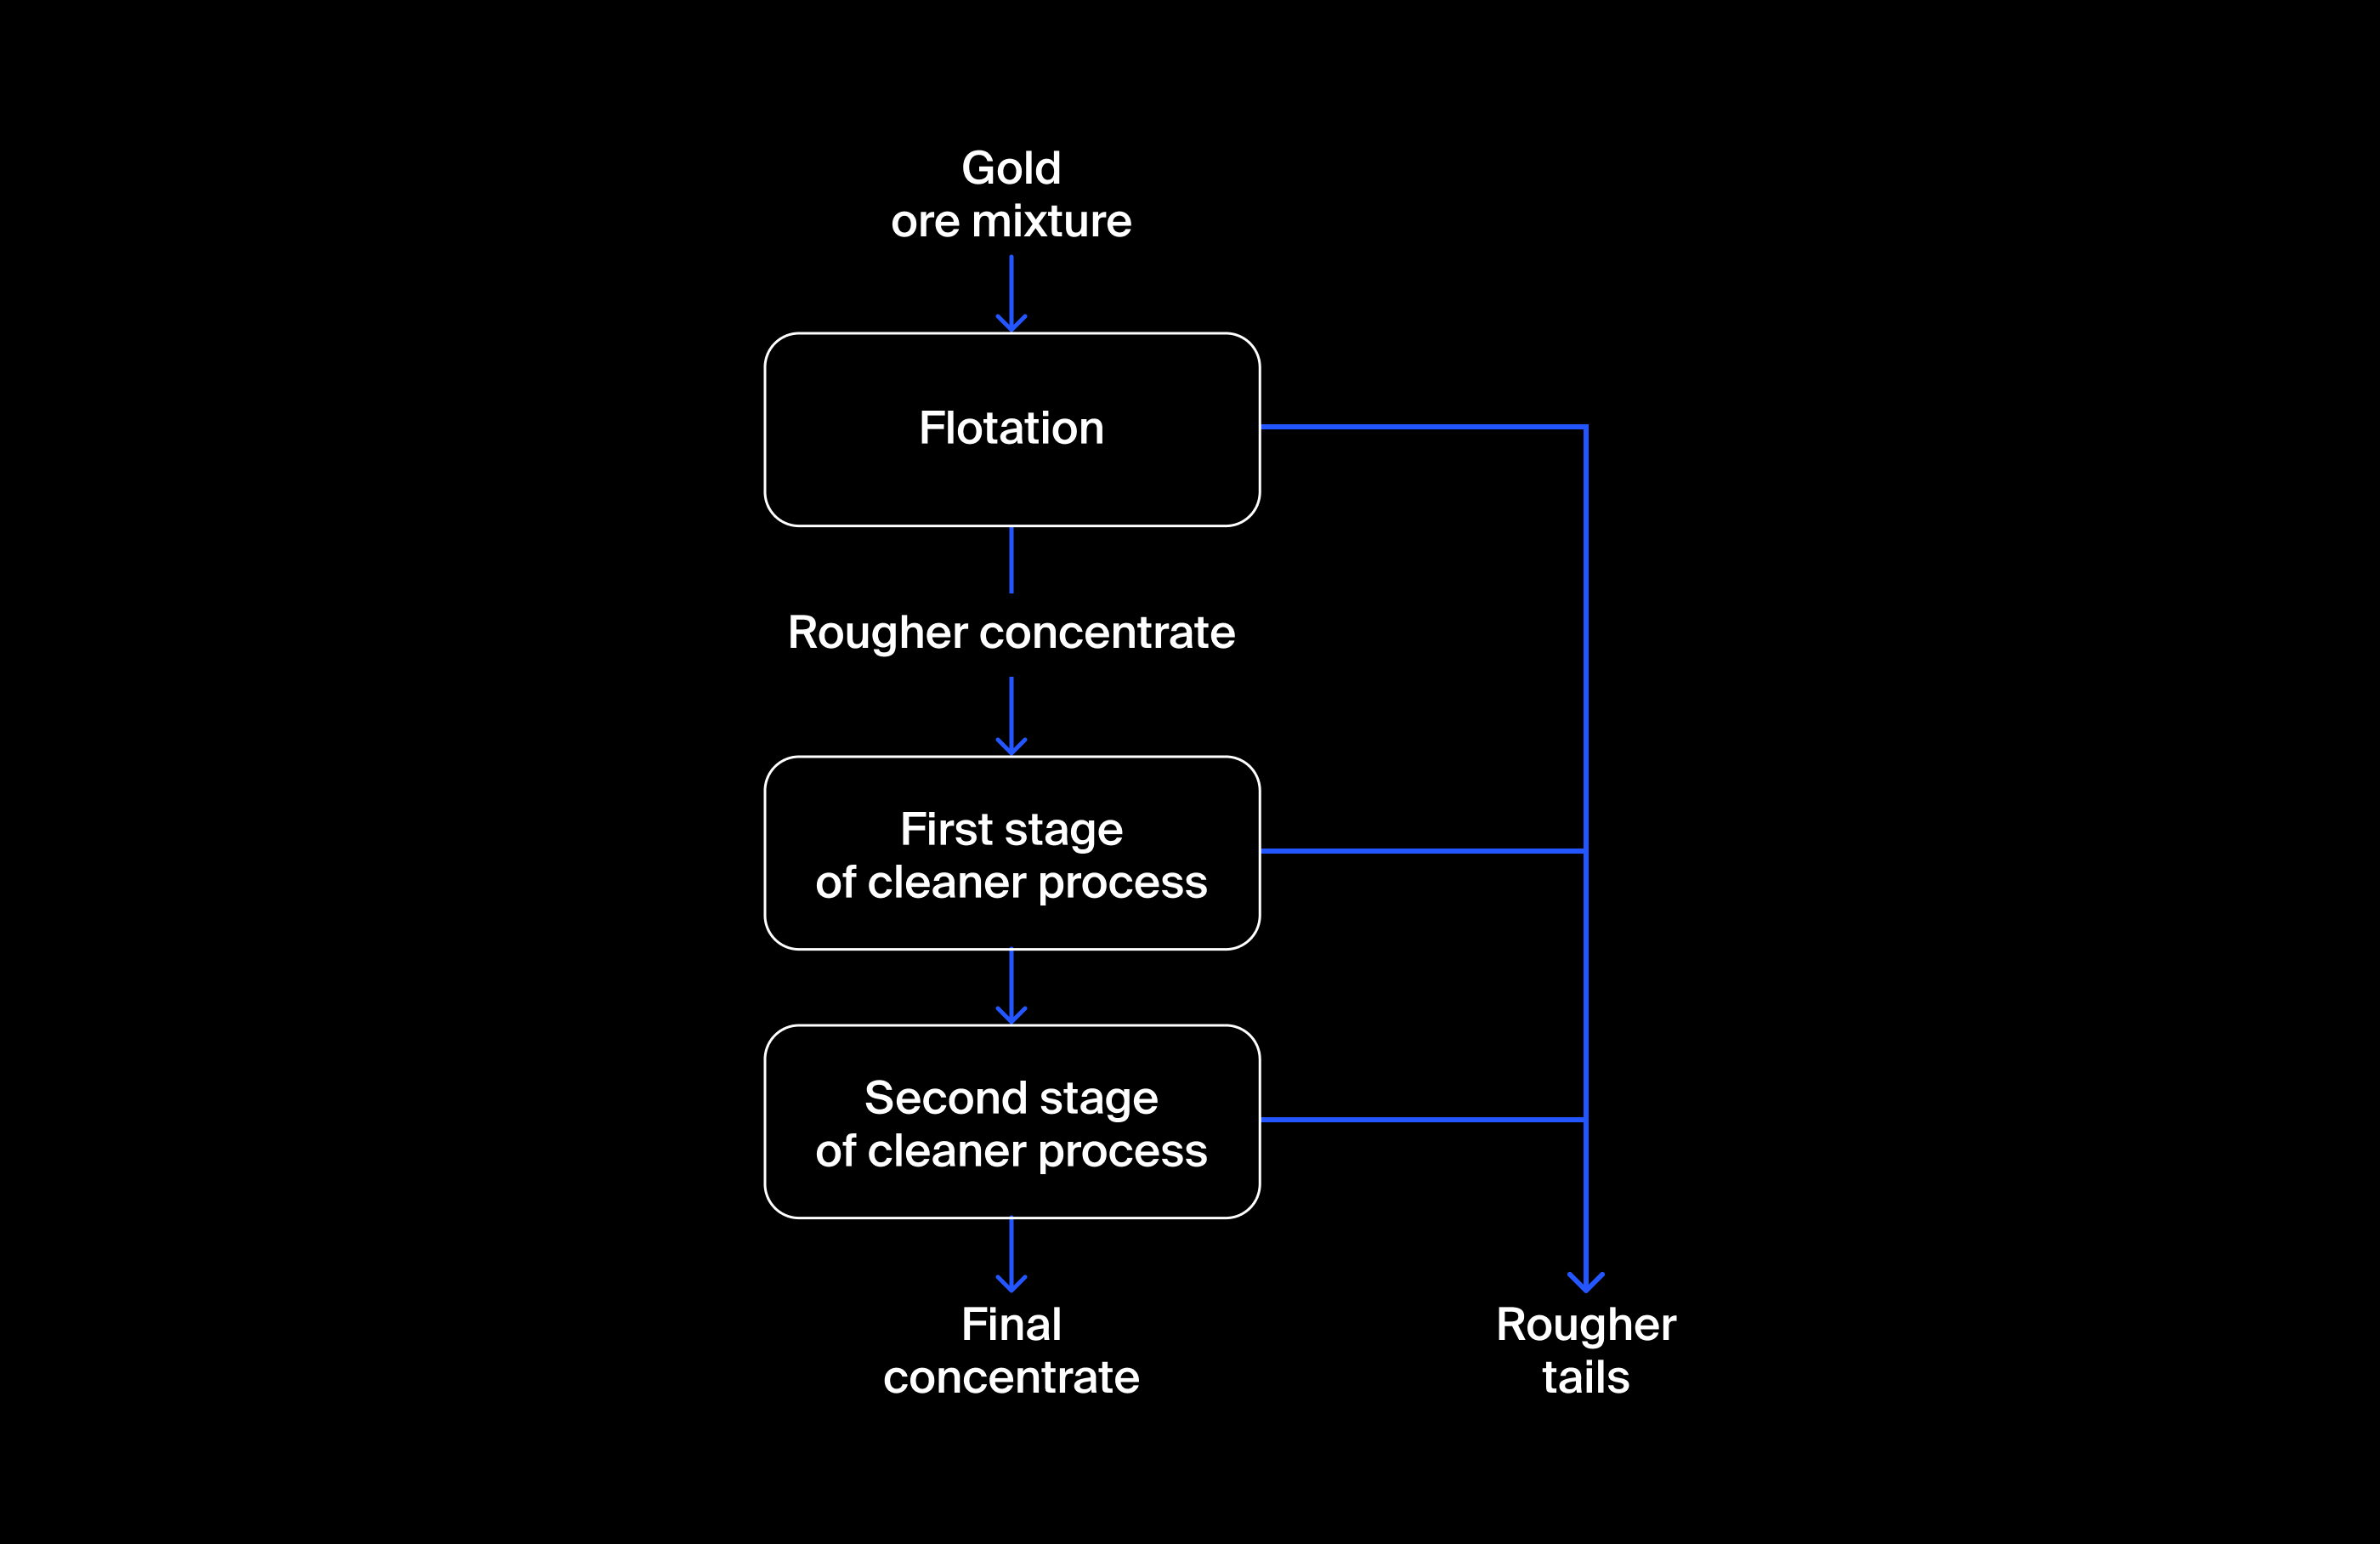


 1. Flotation
 
Gold ore mixture is fed into the float banks to obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals).
The stability of this process is affected by the volatile and non-optimal physicochemical state of the flotation pulp (a mixture of solid particles and liquid).

 2. Purification
 
The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.

 


# Data Description

The data is stored in three files:
 - gold_recovery_train.csv — training dataset 
 - gold_recovery_test.csv — test dataset
 - gold_recovery_full.csv — source dataset

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

**Technological process:**

 - Rougher feed — raw material
 - Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
    - Xanthate — promoter or flotation activator;
    - Sulphate — sodium sulphide for this particular process;
    - Depressant — sodium silicate.
 - Rougher process — flotation
 - Rougher tails — product residues
 - Float banks — flotation unit
 - Cleaner process — purification
 - Rougher Au — rougher gold concentrate
 - Final Au — final gold concentrate
 
**Parameters of stages:**

 - air amount — volume of air
 - fluid levels
 - feed size — feed particle size
 - feed rate
 
**Feature naming:**

Here's how you name the features: [stage].[parameter_type].[parameter_name]. Example: rougher.input.feed_ag. 

Possible values for [stage]:

 - rougher — flotation
 - primary_cleaner — primary purification
 - secondary_cleaner — secondary purification
 - final — final characteristics

Possible values for [parameter_type]:

 - input — raw material parameters
 - output — product parameters
 - state — parameters characterizing the current state of the stage
 - calculation — calculation characteristics



# Recovery calculation

 Formula to simulate the recovery process:
 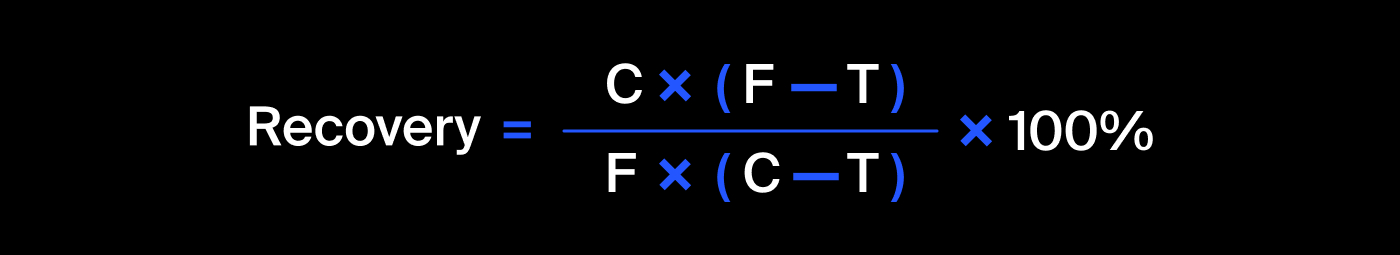
 
 Where:
 
 - C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
 - F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
 - T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
 

# Evaluation metric

sMAPE, symmetric Mean Absolute Percentage Error Formula:

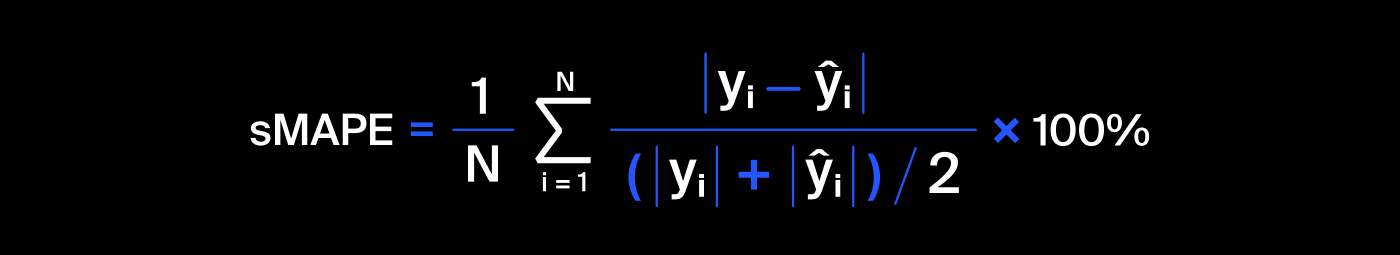

Denotation:

 - Yᵢ - Value of target for the observation with the i index in the sample used to measure quality.
 - Ŷᵢ - Value of prediction for the observation with the i index, for example, in the test sample.
 - N - Number of observations in the sample.
 - ∑ - Summation over all observations of the sample (i takes values from 1 to N).
 



The final metric includes the two values:

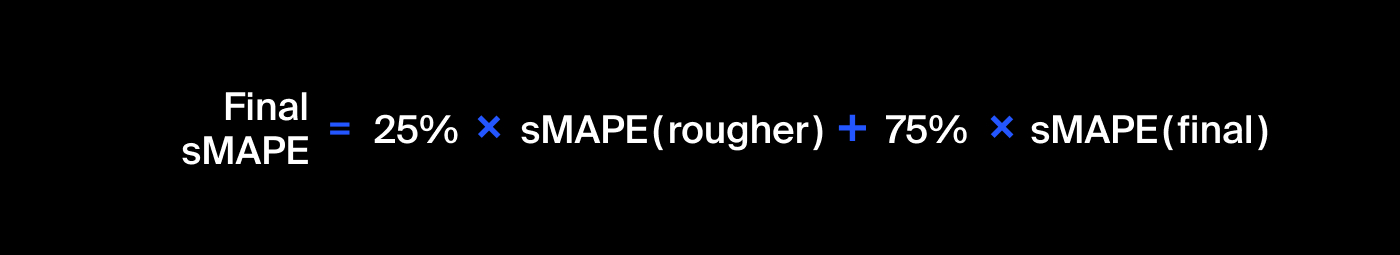

# Project steps:

  1. **Prepare the data:**
    - Open the files and look into the data. 
    - Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
    - Analyze the features not available in the test set. What are these parameters? What is their type?
    - Perform data preprocessing.
    
  2. **Analyze the data:**
    - Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
    - Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
    - Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
    
  3. **Build the model:**
    - Write a function to calculate the final sMAPE value.
    - Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.
  

In [1]:
#import of libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

## Prepare the data.

### Open the files and look into the data.

In [2]:
try:
    df_train = pd.read_csv('/Users/yoheved/Desktop/Study/gold_recovery_train.csv')
except:
    df_train = pd.read_csv('/datasets/gold_recovery_train.csv')

In [3]:
try:
    df_test = pd.read_csv('/Users/yoheved/Desktop/Study/gold_recovery_test.csv')
except:
    df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

In [4]:
try:
    df_full = pd.read_csv('/Users/yoheved/Desktop/Study/gold_recovery_full.csv')
except:
    df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [5]:
#creating a function for displaying the main information about datasets:
def df_info(df):
    print('DataFrame:')
    display(df.head())
    print('------------------------------------------------------------------------------------------')
    print('Info:')
    print('')
    print(df.info())
    print('------------------------------------------------------------------------------------------')
    print('Shape')
    print('')
    display(df.shape)

Let's check what we have in our datasets.

In [6]:
df_info(df_train)

DataFrame:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 n

(16860, 87)

In [7]:
df_info(df_test)

DataFrame:


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   

(5856, 53)

In [8]:
df_info(df_full)

DataFrame:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 n

(22716, 87)

In [9]:
len(df_train) + len(df_test)

22716

On the first look I can see that train and test sets were taken from the full dataset, in test set there are only 53 columns while in train set - 87. The reason can be the test sample separates the target features, but the training sample does not.
It is likely that the training sample was separated from the test sample on a temporal basis, since the column with the date in the training sample has a round time value, while in the test sample all time values end at the last minute of the hour.

### Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [10]:
#creating a function for calculating recovery:
def calc_recovery(c, f, t):
    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    recovery[recovery < 0] = np.nan
    recovery[recovery > 100] = np.nan
    return recovery

In [11]:
#creating the column with calculations:
df_train['rougher.output.calc'] = calc_recovery(df_train['rougher.output.concentrate_au'],
           df_train['rougher.input.feed_au'], df_train['rougher.output.tail_au'])

In [12]:
#comparing results:
df_train[['rougher.output.recovery', 'rougher.output.calc']].head()


,rougher.output.recovery,rougher.output.calc
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [13]:
#filling NA with 0 for MAE calculations:
df_train['rougher.output.recovery'].fillna(0, inplace=True)
df_train['rougher.output.calc'].fillna(0, inplace=True)

In [14]:
mean_absolute_error(df_train['rougher.output.recovery'], df_train['rougher.output.calc'])

7.883623897364653e-15

The MAE value is low which means that means that recovery calculations is corect

### Analyze the features not available in the test set. What are these parameters? What is their type?

In [15]:
test_columns = df_test.columns
df_non_test_columns = df_full.drop(test_columns, axis=1)

In [16]:
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                           how = 'left', on = 'date')

In [17]:
df_info(df_non_test_columns)

DataFrame:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448


------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 n

(22716, 34)

Apparently, here we are dealing with the output values of raw materials and other chemicals that are obtained at different stages of enrichment of raw materials.

###  Perform data preprocessing.

In [18]:
df_full['date'] = pd.to_datetime(df_full['date'])
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [19]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [20]:
df_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

You can see that all columns have missing values. It is likely that the omissions may be due to different stages of enrichment.

First, let's take the training sample and leave in it only those columns that participate in the test sample:

In [21]:
df_train = df_train[df_test.columns]
df_train.shape

(16860, 55)

In [22]:
#checking missing values in test and train sets:
df_train.isna().sum()

date                                             0
primary_cleaner.input.sulfate                 1307
primary_cleaner.input.depressant              1262
primary_cleaner.input.feed_size                  0
primary_cleaner.input.xanthate                 985
primary_cleaner.state.floatbank8_a_air          40
primary_cleaner.state.floatbank8_a_level        33
primary_cleaner.state.floatbank8_b_air          40
primary_cleaner.state.floatbank8_b_level        27
primary_cleaner.state.floatbank8_c_air          38
primary_cleaner.state.floatbank8_c_level        27
primary_cleaner.state.floatbank8_d_air          39
primary_cleaner.state.floatbank8_d_level        27
rougher.input.feed_ag                           82
rougher.input.feed_pb                          228
rougher.input.feed_rate                        513
rougher.input.feed_size                        417
rougher.input.feed_sol                         292
rougher.input.feed_au                           83
rougher.input.floatbank10_sulfa

In [23]:
df_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


There are missing values in both samples. Let's replace all the missing values to mean values. Looking ahead, I tried methods to remove them and replace them with zero values. The option with the replacement with mean ones showed the best results.

In [24]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [25]:
df_train.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [26]:
df_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [27]:
print(df_train.shape, df_test.shape, sep=' | ')

(16860, 55) | (5856, 55)


No we have sets without missing values and we can continue to work with it.

## Analyze the data

### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [28]:
elements = {'gold': 'au', 'silver': 'ag', 'lead': 'pb'}
elements

{'gold': 'au', 'silver': 'ag', 'lead': 'pb'}

In [29]:
#creating function for visualizaition with values > 0 in order to see the picture wothout outliers: 
def concentrate_viz(e):
    cols = ['rougher.input.feed_'+e, 'rougher.output.concentrate_'+e, 
            'primary_cleaner.output.concentrate_'+e, 'final.output.concentrate_'+e]
    concentrate = df_full[cols]  
    sns.displot(df_full[cols], 
            legend=True, 
            kde=True, 
            height=7.7, 
            aspect=1.5)
    plt.title('Concentration of ' + str(e).title() + ' on the different stages', fontsize=16)
    plt.figure(figsize=(12.8,8))
    plt.xticks(rotation=0)
    sns.boxplot(data=df_full[cols])

**Gold concentration:**

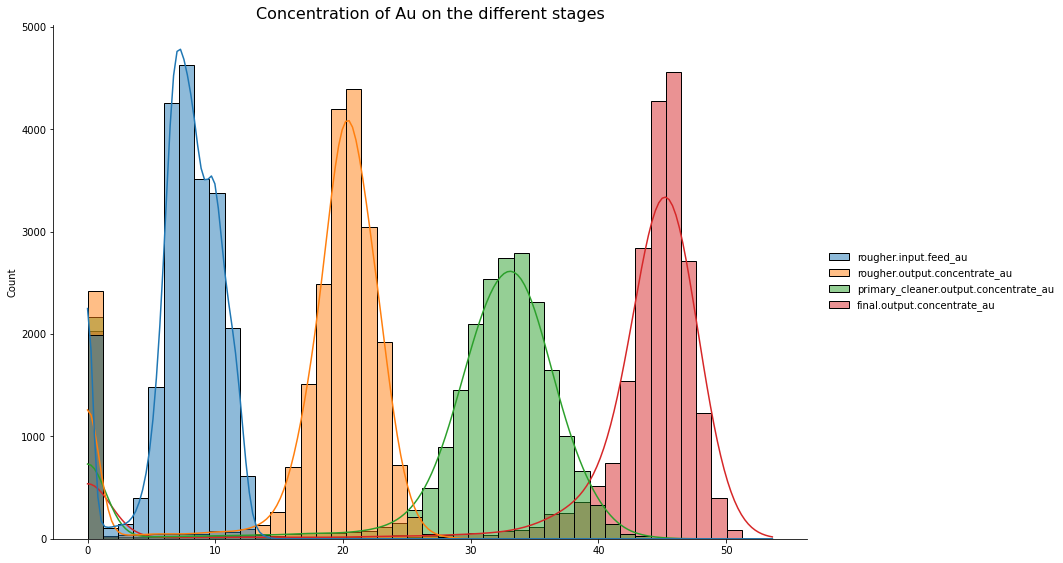

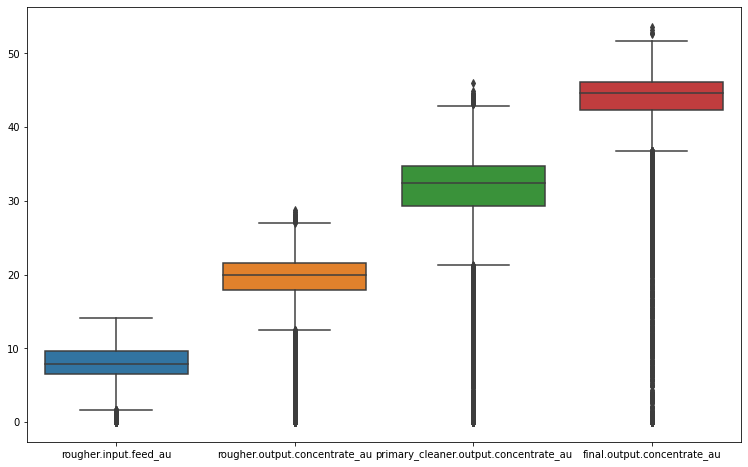

In [30]:
concentrate_viz(elements['gold'])

It can be seen that with every next step the concentration of gold is higher than on previous. Also we can see from th3e boxplots that we on every stage we have outliers.

**Silver concentration:**

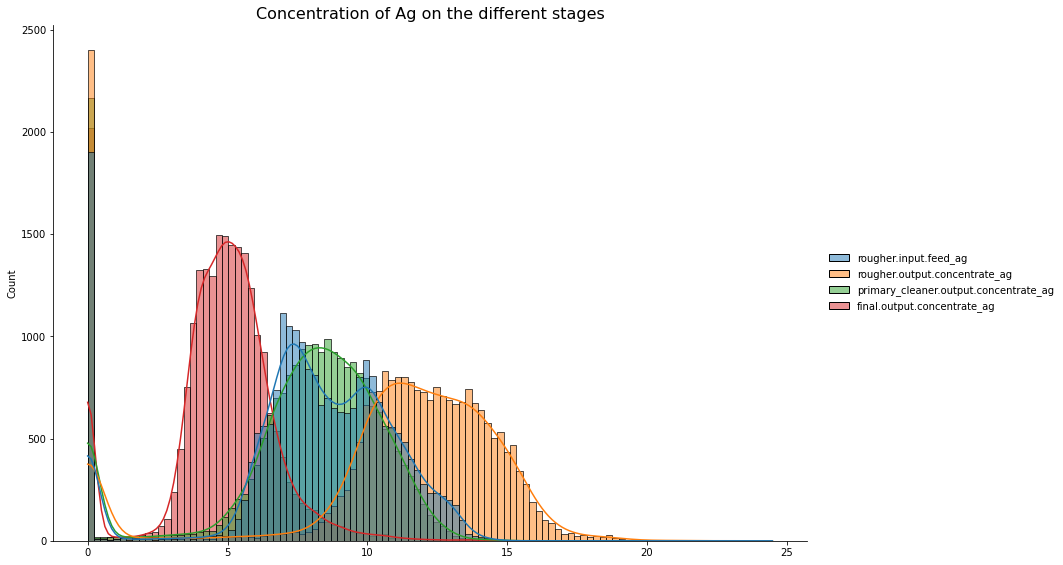

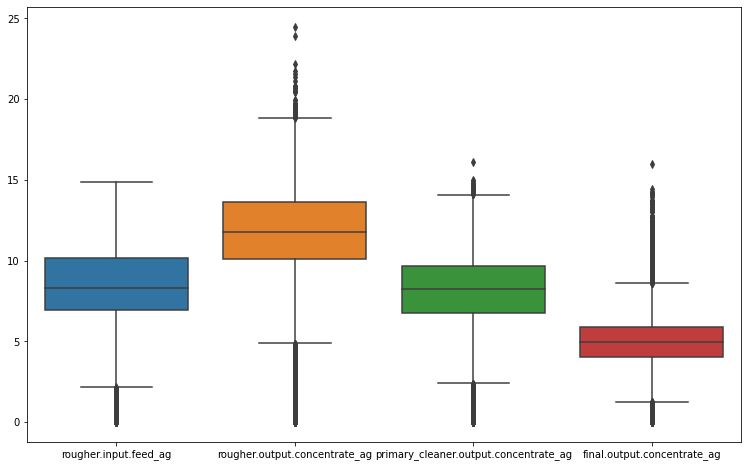

In [31]:
concentrate_viz(elements['silver'])

Here we see that at each stage the distribution becomes smaller, and the concentration decreases.
Also we have outliers here.


**Concentration of Lead:**

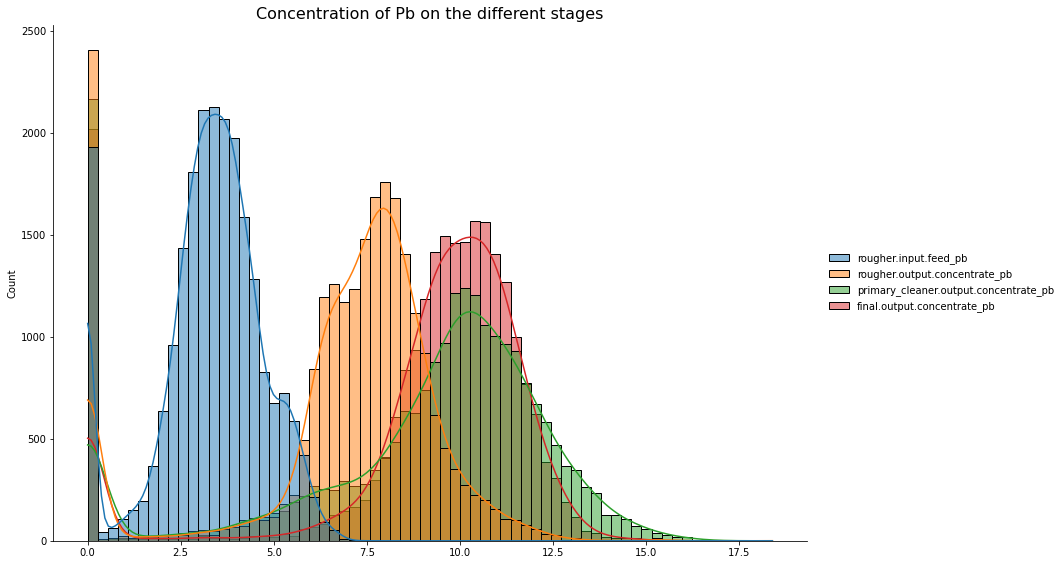

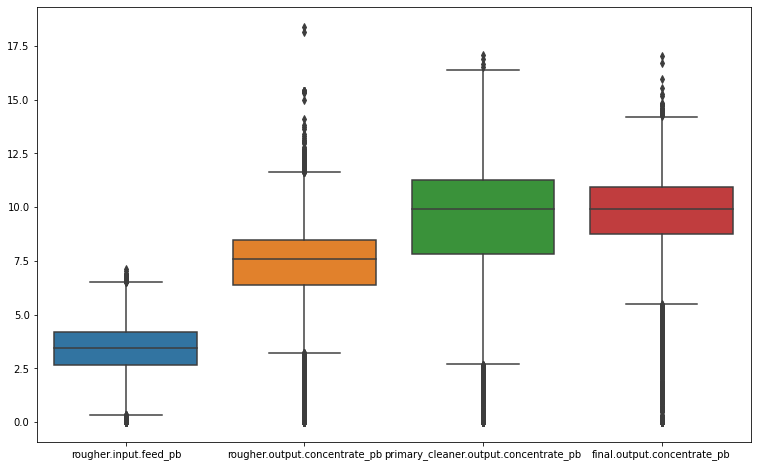

In [32]:
concentrate_viz(elements['lead'])

From the graphs above we can see that the concentration of lead gradually increases during the first 3 stages of purification. Least of all lead at the beginning of the process, i.e., when it is part of a mixture of gold-bearing ore. Interestingly, at the last 2 stages, the median indicator almost coincides, but at the same time, the spread of values decreases at the final stage.

There are outliers also.

### Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

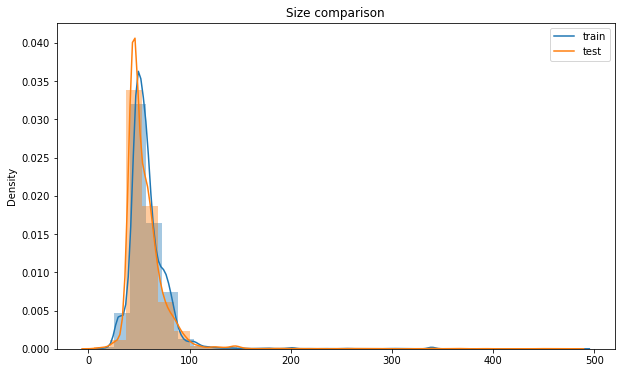

In [33]:
rougher_train_concentration = df_train[df_train['rougher.input.feed_size'] > 1]
rougher_test_concentration = df_test[df_test['rougher.input.feed_size'] > 1]
    
plt.figure(figsize=(10, 6))
sns.distplot(rougher_train_concentration[['rougher.input.feed_size']], bins=30)
sns.distplot(rougher_test_concentration[['rougher.input.feed_size']], bins=30)
plt.legend(['train', 'test'])
plt.title('Size comparison')
plt.show()

In general, the distributions are slightly different, but not critical. It can be seen that the test sample is dominated by larger granules.



### Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

In [34]:
first = 'rougher.input.feed_'
second = 'rougher.output.concentrate_'
third = 'primary_cleaner.output.concentrate_'
fourth = 'final.output.concentrate_'

In [35]:
df_full['raw_material'] = df_full[[first+'au', first+'ag', first+'pb']].sum(axis=1)
df_full['draft_concentrate'] = df_full[[second+'au', second+'ag', second+'pb']].sum(axis=1)
df_full['concentrate_after_filtering'] = df_full[[third+'au', third+'ag', third+'pb']].sum(axis=1)
df_full['final_concentrate'] = df_full[[fourth+'au', fourth+'ag', fourth+'pb']].sum(axis=1)

In [36]:
df_full[['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']].describe()

,raw_material,draft_concentrate,concentrate_after_filtering,final_concentrate
count,22716.000000,22716.000000,22716.000000,22716.000000
mean,18.833952,35.500849,45.489901,53.673032
std,7.418530,13.401008,16.248774,17.975586
min,0.000000,0.000000,0.000000,0.000000
25%,16.447446,37.326591,48.745632,58.684224
50%,19.560398,39.961497,51.517962,60.073814
75%,23.572584,42.181417,53.156499,60.990543
max,35.071987,55.568687,60.269003,65.575259


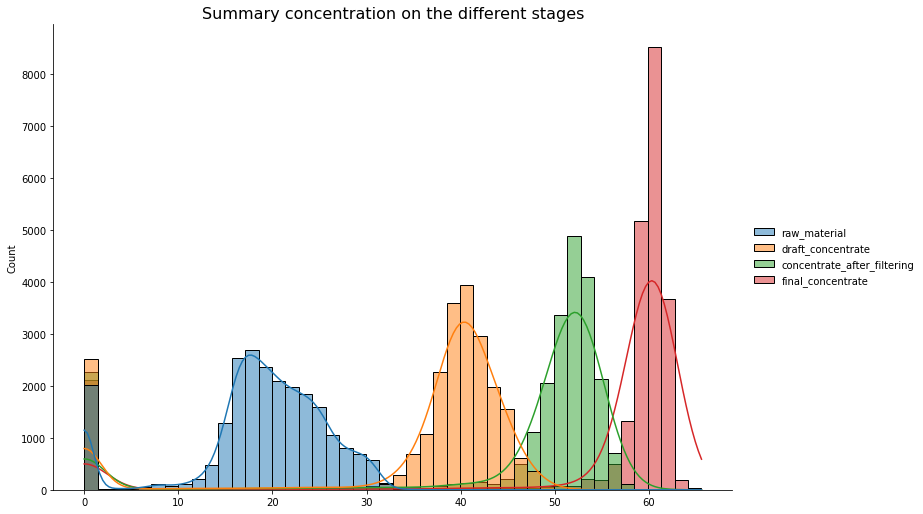

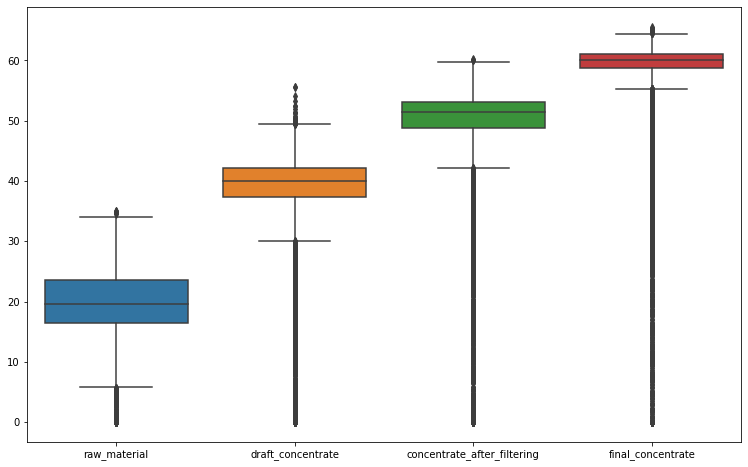

In [37]:
cols_all = ['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']
    
concentrate = df_full[cols_all]    
    
sns.displot(df_full[cols_all], 
            legend=True, 
            kde=True, 
            height=7, 
            aspect=1.5)
    
plt.title('Summary concentration on the different stages', fontsize=16)
    
plt.figure(figsize=(12.8,8))
plt.xticks(rotation=0)
sns.boxplot(data=df_full[cols_all])
plt.show()

There are outliers with 0 values. It can be connect with non metal materials in the raw. However they can affect the work of our models so it will be better to drop them.

In [38]:
for col in cols_all:
    print(col, 'zeros:', len(df_full[df_full[col] == 0]))
    print(col, 'under 1:', len(df_full[df_full[col] < 1]))
    print('\n')

raw_material zeros: 1626
raw_material under 1: 2007


draft_concentrate zeros: 2051
draft_concentrate under 1: 2504


concentrate_after_filtering zeros: 1724
concentrate_after_filtering under 1: 2260


final_concentrate zeros: 1699
final_concentrate under 1: 2105




In [39]:
full_clean = df_full[
    (df_full['raw_material'] >  1) & 
    (df_full['draft_concentrate'] > 1) & 
    (df_full['concentrate_after_filtering'] > 1) & 
    (df_full['final_concentrate'] > 1)
]

full_clean.shape

(19575, 91)

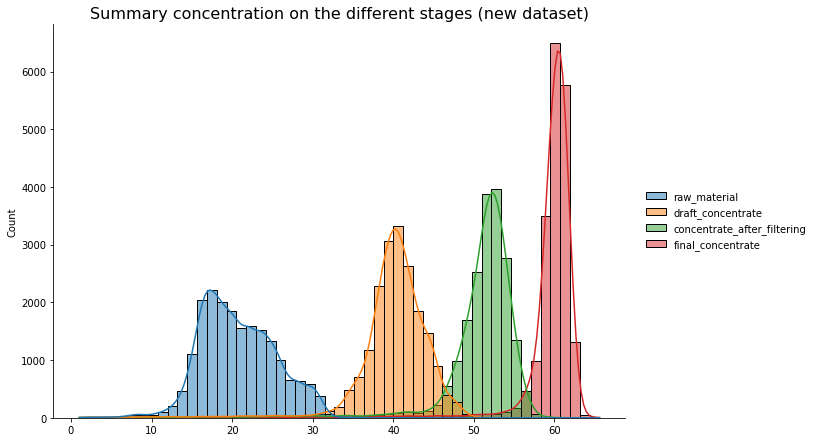

In [40]:
sns.displot(full_clean[['raw_material', 'draft_concentrate', 
                       'concentrate_after_filtering', 'final_concentrate']], 
            legend=True, 
            kde=True, 
            height=6, 
            aspect=1.5)
plt.title('Summary concentration on the different stages (new dataset)', fontsize=16)
plt.show()

In [41]:
full_clean[['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']].describe()

,raw_material,draft_concentrate,concentrate_after_filtering,final_concentrate
count,19575.000000,19575.000000,19575.000000,19575.000000
mean,20.733002,40.035789,50.757705,59.335867
std,4.637593,4.732761,5.546544,4.992355
min,1.130990,1.137053,1.037408,1.084495
25%,17.250835,38.494072,49.961182,59.235753
50%,20.219502,40.398724,51.853851,60.268208
75%,23.988143,42.493014,53.318204,61.066597
max,35.071987,55.568687,60.106566,65.575259


Train set:

In [42]:
train_clean = df_train[df_train['date'].isin(full_clean['date'])]
train_clean.dropna(inplace=True)
print('Train set', train_clean.shape)

Train set (14335, 55)


Test set:

In [43]:
test_clean = df_test[df_test['date'].isin(full_clean['date'])]
test_clean.dropna(inplace=True)
print('Test set', test_clean.shape)

Test set (5240, 55)


##  Build the model


### Write a function to calculate the final sMAPE value.

sMAPE = 25% sMAPE(rougher) + 75% sMAPE(final)

In [44]:
def total_smape(smape_rougher, smape_final):
    final_result = 0.25 * smape_rougher + 0.75 * smape_final
    return final_result

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

For models I will use cross validation. It is necessary to add target features to the training and test samples. These are the columns "rougher.output.recovery" and "final.output.recovery". Let's create our own training and test samples, and targets for each target feature

In [45]:
# train set:
target_rougher_train = train_clean['rougher.output.recovery']
target_final_train = train_clean['final.output.recovery']
features_train = train_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

#test set:
target_rougher_test = test_clean['rougher.output.recovery']
target_final_test = test_clean['final.output.recovery']
features_test = test_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [46]:
print('features_train', features_train.shape)
print('features_test', features_test.shape)

features_train (14335, 52)
features_test (5240, 52)


In [47]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [48]:
features_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.163144,0.358103,-0.110807,0.275085,-0.440904,-0.303456,-0.423807,-0.800065,-0.430060,-0.276206,...,-1.041743,-0.467231,-0.635067,-0.756150,-1.156730,-0.380062,-0.859998,-0.426918,-0.938255,-2.627458
1,-0.199469,0.407362,-0.110807,0.311963,-0.235809,-0.359160,-0.237114,-0.321997,-0.235742,-0.294497,...,-1.046092,-0.526362,-0.663572,-0.698061,-1.137223,-0.428784,-0.876594,-0.429760,-0.964956,-2.467069
2,-0.244403,0.706524,-0.110807,0.281733,-0.038497,-0.333802,-0.051033,-0.343443,-0.042250,-0.338353,...,-1.042065,-0.467876,-0.670775,-0.694660,-1.131786,-0.427714,-0.871502,-0.428109,-0.959666,-2.510516
3,-0.282885,0.708243,-0.110807,0.296250,-0.050833,-0.360469,-0.048957,-0.316539,-0.054892,-0.334346,...,-1.038258,-0.435253,-0.654219,-0.695695,-1.149050,-0.403416,-0.877894,-0.421422,-0.963700,-2.472604
4,-0.389222,0.881714,-0.110807,0.331076,-0.040179,-0.305226,-0.043028,-0.335218,-0.060265,-0.338863,...,-1.039890,-0.415276,-0.663088,-0.693296,-1.156717,-0.468519,-0.892422,-0.423981,-0.965254,-2.512353


In [49]:
random_state = 123
cv = 5

In [50]:
models = [DecisionTreeRegressor(random_state = random_state), 
          RandomForestRegressor(random_state=random_state), 
          LinearRegression()]

In [51]:
#creating a function for sMAPE score:
def smape_scorer(target, predictions):
    smape = ((1 / len(target)) * (abs(target - predictions) / ((abs(target) + abs(predictions)) / 2))).sum() * 100
    return smape

In [52]:
#creating a function for scoring the model:
def fit_and_check(model, params, df_train, df_target):
    my_scorer = make_scorer(smape_scorer, greater_is_better=False)
    clf = GridSearchCV(model, params, scoring=my_scorer, cv=5)
    clf.fit(df_train, df_target)
    
    return clf.best_estimator_, clf.best_score_

Let's check linear regression, decision tree and random forest models. 

In [53]:
results_cross_val = []

for model in models: 
    
    scorer = make_scorer(smape_scorer, greater_is_better=False) 
    
    cross_val_score_rougher = cross_val_score(model, 
                                              features_train, 
                                              target_rougher_train, 
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, 
                                            features_train, 
                                            target_final_train, 
                                            cv=cv, scoring=scorer).mean()

    results_cross_val.append({'model name': model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final}) 
              
pd.DataFrame(results_cross_val)

,model name,cross_val_score_rougher,cross_val_score_final
0,DecisionTreeRegressor,-40.751981,-14.541129
1,RandomForestRegressor,-27.469484,-9.642616
2,LinearRegression,-20.876236,-11.324803


The best result is shown by the random forest model. We select hyperparameters and try to improve the performance of the model.

In [54]:
%%time 
results = []

for depth in range(1,5):
    
    for estimator in range(10, 21, 5):
        
        model = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=estimator, 
                                       max_depth=depth)
        
        scorer = make_scorer(smape_scorer, greater_is_better=False) 
    
        cross_val_score_rougher = cross_val_score(model, features_train, target_rougher_train, cv=cv, scoring=scorer).mean()
        cross_val_score_final = cross_val_score(model, features_train, target_final_train, cv=cv, scoring=scorer).mean()

        smape_final_result = total_smape(cross_val_score_rougher, cross_val_score_final)

        results.append({'model name': model.__class__.__name__, 
                        'Hyperparameters': {'random_state': random_state, 
                                            'n_estimators': estimator, 
                                            'max_depth':depth}, 
                        'smape_final_result': smape_final_result})

pd.DataFrame(results).style.highlight_max(color = 'lightgreen', axis = 0)

CPU times: user 3min 30s, sys: 140 ms, total: 3min 30s
Wall time: 3min 31s


,model name,Hyperparameters,smape_final_result
0,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 1}",-12.263326
1,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 1}",-12.292173
2,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 1}",-12.301437
3,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 2}",-11.698223
4,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 2}",-11.765462
5,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 2}",-11.735301
6,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 3}",-11.705634
7,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 3}",-11.647380
8,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 3}",-11.646547
9,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 4}",-11.589078


As we see the best scoring has a Random Forest model. After checjing it with hypermarameters I found out that the best result showed model with n_estimators - 15 and max_depth - 4

**The best models training**

In [55]:
model_final = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=15, 
                                       max_depth=4)

model_final.fit(features_train, target_rougher_train)
predictions_r = model_final.predict(features_test)

model_final.fit(features_train, target_final_train)
predictions_f = model_final.predict(features_test)

In [56]:
smape_r = smape_scorer(target_rougher_test, predictions_r)
smape_f = smape_scorer(target_final_test, predictions_f)

print('Final sMAPE:', total_smape(smape_r, smape_f))

Final sMAPE: 9.231778553023219


In [57]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_rougher_train)
predictions_r_dummy = dummy_regr.predict(features_test)

dummy_regr.fit(features_train, target_final_train)
predictions_f_dummy = dummy_regr.predict(features_test)

In [58]:
smape_r_dummy = smape_scorer(target_rougher_test, predictions_r_dummy)
smape_f_dummy = smape_scorer(target_final_test, predictions_f_dummy)

print('Final sMAPE', total_smape(smape_r_dummy, smape_f_dummy))

Final sMAPE 8.735114730782414


The random forest model showed the best results.Sanity check also was successfull.

# Conclusion

The goal of the project - to prepare a prototype of a machine learning model that should predict the recovery rate of gold from gold ore - has been achieved.
During the project, the data was processed and analyzed, on the basis of which a random forest model was built and trained. The final model performs better than the constant model: the error of the trained model is 7,7%, the error of the constant model is 7.9%.
The following steps were taken during the project:

 1. read and studied the data (prepared an EDA report for each dataset)
 2. pre-processed data (processing missing values, replacing data type, checking for duplicates)
 3. made sure that the enrichment efficiency is calculated correctly.
 4. checked how the concentration of metals (Au, Ag, Pb) changes at different stages of purification. We can conclude that the concentration of each of the metals varies depending on the stage of purification: the concentration of gold gradually increases with each stage, silver decreases, and lead increases in the first 3 stages.
 5. conducted an analysis of the size of the granules on the training and test sets and made sure that the sizes of the granules are approximately equally distributed in the training and test sets.
 6. analyzed the total concentration of all metals at different stages, found and removed anomalies (a large number of zeros) from all datasets.
 7. wrote functions for calculating sMAPE and final sMAPE
 8. compared the work of different models (DecisionTreeRegressor (), RandomForestRegressor, LinearRegression) and how the best random forest model was chosen with hyperparameters n_estimators = 15 and max_depth = 4. The work of the final model was tested on a test sample, where it showed a good result: the error of the trained model is 7.7% , constant - 7.9%.